In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('spy_data.csv')

# Data analysis

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

In [7]:
df['Unnamed: 0']=pd.to_datetime(df['Unnamed: 0'])
df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

<Figure size 1000x400 with 0 Axes>

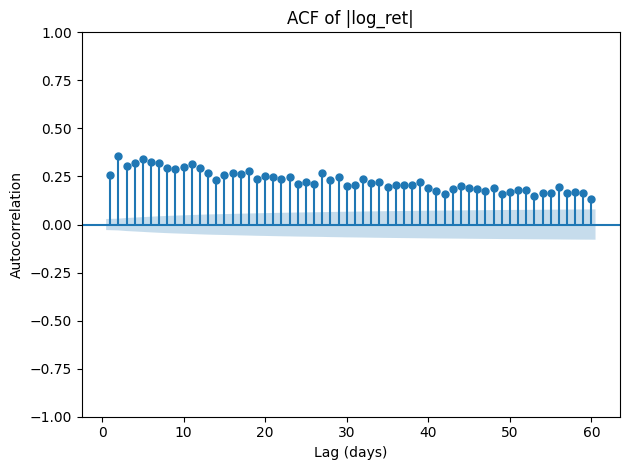

In [5]:
x = df['log_ret'].astype(float).abs()
plt.figure(figsize=(10, 4))
plot_acf(x, lags=60, zero=False)
plt.title("ACF of |log_ret|")
plt.xlabel("Lag (days)")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

<Figure size 1000x400 with 0 Axes>

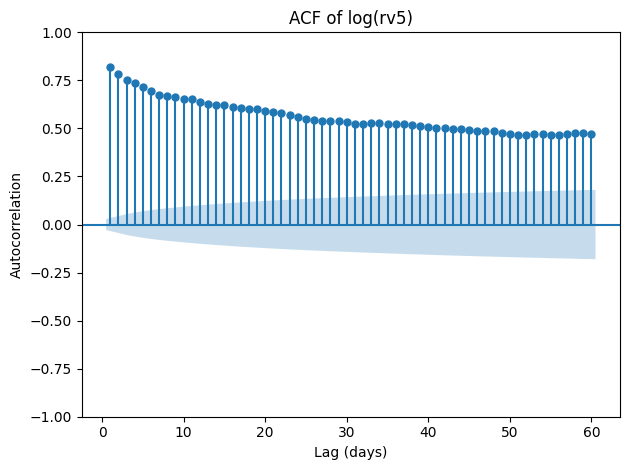

In [6]:
y = np.log(df['rv5'].astype(float)).replace([np.inf, -np.inf], np.nan)

plt.figure(figsize=(10, 4))
plot_acf(y, lags=60, zero=False)
plt.title("ACF of log(rv5)")
plt.xlabel("Lag (days)")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

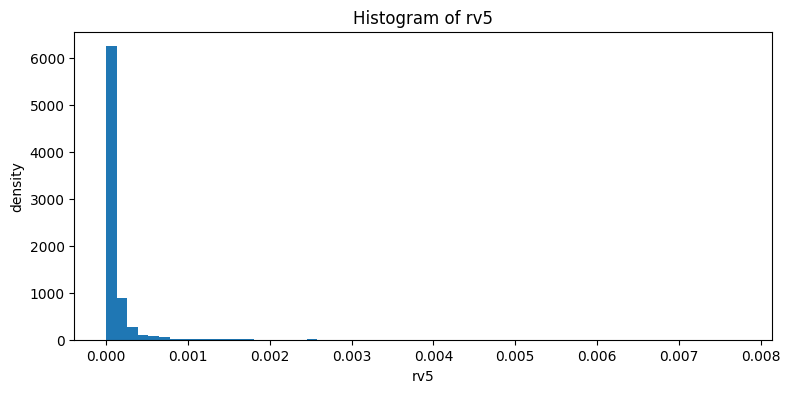

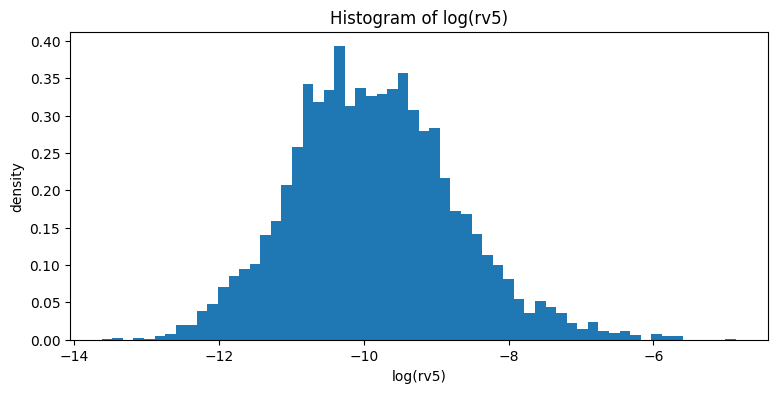

Skewness rv5      : 11.713361380689644
Skewness log(rv5) : 0.3269787535435556


In [4]:
rv = df["rv5"].astype(float).dropna()


rv_pos = rv[rv > 0]
log_rv = np.log(rv_pos)


plt.figure(figsize=(9,4))
plt.hist(rv_pos, bins=60, density=True)
plt.title("Histogram of rv5")
plt.xlabel("rv5")
plt.ylabel("density")
plt.show()


plt.figure(figsize=(9,4))
plt.hist(log_rv, bins=60, density=True)
plt.title("Histogram of log(rv5)")
plt.xlabel("log(rv5)")
plt.ylabel("density")
plt.show()


def skewness(x):
    x = np.asarray(x)
    m = x.mean()
    s = x.std(ddof=0)
    return np.mean(((x - m) / s) ** 3)

print("Skewness rv5      :", skewness(rv_pos.values))
print("Skewness log(rv5) :", skewness(log_rv.values))


# GARCH model

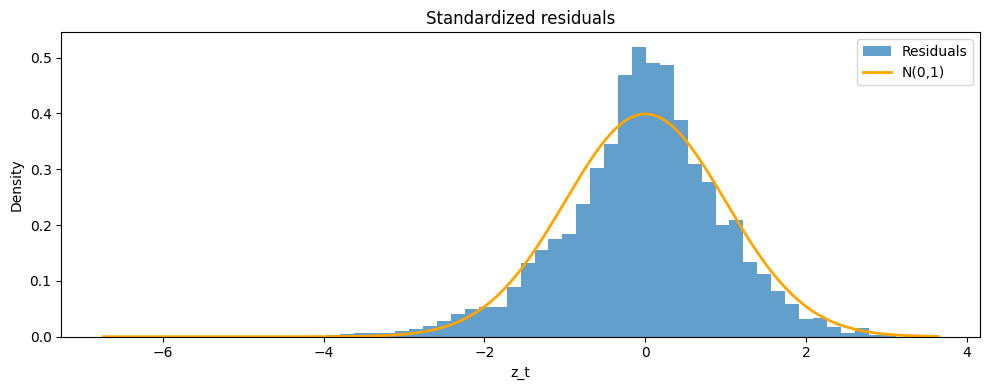

In [ ]:
from scipy.stats import norm
import statsmodels.api as sm
from arch import arch_model


r = df['log_ret'].astype(float).dropna()

#we work in percentage returns for arch_model
r_pct = 100 * r

am = arch_model(r_pct, mean='Constant', vol='GARCH', p=1, q=1, dist='normal')
res = am.fit(disp='off')


std_resid = res.std_resid.dropna()


plt.figure(figsize=(10,4))
plt.hist(std_resid, bins=60, density=True, label='Residuals', alpha=0.7)
x = np.linspace(std_resid.min(), std_resid.max(), 500)
plt.plot(x, norm.pdf(x, loc=0, scale=1), linewidth=2, label='N(0,1)', color='orange')
plt.title("Standardized residuals")
plt.xlabel("z_t")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


<Figure size 600x600 with 0 Axes>

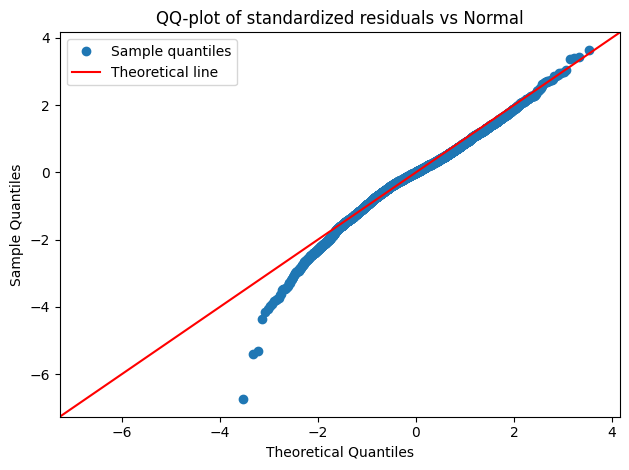

In [ ]:
plt.figure(figsize=(6,6))
sm.qqplot(std_resid, line='45')  
plt.title("QQ-plot of standardized residuals vs Normal")

ax = plt.gca()
ax.get_lines()[0].set_label('Sample quantiles')
ax.get_lines()[1].set_label('Theoretical line')
plt.legend()
plt.tight_layout()
plt.show()

# Feature engineering (using HAR features)

In [8]:
# next-day return 
df['y_next'] = df['log_ret'].shift(-1)

df['log_rv5'] = np.log(df['rv5'])
df['log_bv']  = np.log(df['bv'])

# features (Daily / Weekly / Monthly) on log(RV)
df['har_rv_d'] = df['log_rv5']                          # daily
df['har_rv_w'] = df['log_rv5'].rolling(5).mean()        # 1 week
df['har_rv_m'] = df['log_rv5'].rolling(22).mean()       # 1 mounth

# Jump
df['jump'] = (df['rv5'] - df['bv']).clip(lower=0.0)

# final dataset
feature_cols = ['har_rv_d', 'har_rv_w', 'har_rv_m', 'jump']
df_final = df.dropna(subset=feature_cols + ['y_next']).copy()


# Quantile regression

In [10]:
quantiles = [0.01, 0.05, 0.10]
X = df_final[feature_cols].values
y = df_final['y_next'].values

split = int(0.8 * len(df_final))  
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

dates_train = df_final.index[:split]
dates_test  = df_final.index[split:]



# Parameters Tuning with Grid Search

In [17]:
from metrics import eval_preds, composite_score, kupiec_test

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import QuantileRegressor
from sklearn.model_selection import TimeSeriesSplit

def rolling_quantile_forecast(X, y, start_idx, end_idx, W, k_refit, alpha_reg, quantiles, eval_step=1):
    idx = np.arange(start_idx, end_idx, eval_step)
    preds = {q: np.full(len(idx), np.nan) for q in quantiles}

    scaler = None
    models = {q: None for q in quantiles}
    last_refit_t = None

    for j, t in enumerate(idx):
        # refit au début + tous les k_refit pas (en temps "réel")
        if (last_refit_t is None) or ((t - last_refit_t) >= k_refit):
            tr_start = max(0, t - W)
            X_tr = X[tr_start:t]
            y_tr = y[tr_start:t]

            # sécurité si fenêtre trop courte
            if len(y_tr) < 50:
                # trop peu de points -> on skip (ou tu peux mettre W minimum)
                last_refit_t = t
                continue

            scaler = StandardScaler()
            X_tr_s = scaler.fit_transform(X_tr)

            for q in quantiles:
                m = QuantileRegressor(quantile=q, alpha=alpha_reg, solver="highs")
                m.fit(X_tr_s, y_tr)
                models[q] = m

            last_refit_t = t

        # prédiction au temps t
        X_te_s = scaler.transform(X[t:t+1])
        for q in quantiles:
            preds[q][j] = models[q].predict(X_te_s)[0]

    y_eval = y[idx]
    return idx, y_eval, preds


'\ndef eval_preds(y_eval, preds, quantiles):\n    out = {}\n    for q in quantiles:\n        qhat = preds[q]\n        mask = ~np.isnan(qhat)\n        yv = y_eval[mask]\n        qv = qhat[mask]\n\n        hits = (yv < qv).astype(int)\n        cov = hits.mean()\n        pin = mean_pinball_loss(yv, qv, alpha=q)\n        LR, pval = kupiec_test(hits, q)\n\n        out[q] = dict(\n            actual_coverage=cov,\n            pinball_loss=pin,\n            kupiec_LR=LR,\n            kupiec_pval=pval,\n            nb_violations=int(hits.sum()),\n            n_obs=int(len(hits))\n        )\n    return out\n\ndef composite_score(metrics_by_q, quantiles, lam=0.1):\n\n    scores = []\n    for q in quantiles:\n        m = metrics_by_q[q]\n        # pénalité d\'écart de couverture\n        scores.append(m["pinball_loss"] + lam * abs(m["actual_coverage"] - q))\n    return float(np.mean(scores))\n'

In [ ]:
window_size = [500, 1000]
rebalancing = [21, 63, 123]
alpha_reg_grid = [10e-4, 10e-3, 10e-2] 


tscv = TimeSeriesSplit(n_splits=3) 
eval_step = 5  

rows = []
for W in window_size:
    for k in rebalancing:
        for a_reg in alpha_reg_grid:

            fold_scores = []
            fold_metrics_store = []

            for fold, (tr_idx, va_idx) in enumerate(tscv.split(X_train)):
                va_start = va_idx[0]
                va_end = va_idx[-1] + 1

  
                _, y_val, preds = rolling_quantile_forecast(
                    X_train, y_train,
                    start_idx=va_start, end_idx=va_end,
                    W=W, k_refit=k, alpha_reg=a_reg,
                    quantiles=quantiles,
                    eval_step=eval_step
                )

                metrics = eval_preds(y_val, preds, quantiles)
                score = composite_score(metrics, quantiles, lam=0.1)

                fold_scores.append(score)
                fold_metrics_store.append(metrics)

            avg_score = float(np.mean(fold_scores))

            avg_metrics = {}
            for q in quantiles:
                avg_metrics[q] = {
                    "actual_coverage": float(np.mean([fm[q]["actual_coverage"] for fm in fold_metrics_store])),
                    "pinball_loss":   float(np.mean([fm[q]["pinball_loss"] for fm in fold_metrics_store])),
                    "kupiec_pval":    float(np.nanmean([fm[q]["kupiec_pval"] for fm in fold_metrics_store])),
                }

            rows.append({
                "W": W, "k_refit": k, "alpha_reg": a_reg,
                "score": avg_score,
                "cov_1%": avg_metrics[0.01]["actual_coverage"],
                "cov_5%": avg_metrics[0.05]["actual_coverage"],
                "cov_10%": avg_metrics[0.10]["actual_coverage"],
                "pin_1%": avg_metrics[0.01]["pinball_loss"],
                "pin_5%": avg_metrics[0.05]["pinball_loss"],
                "pin_10%": avg_metrics[0.10]["pinball_loss"],
                "pval_1%": avg_metrics[0.01]["kupiec_pval"],
                "pval_5%": avg_metrics[0.05]["kupiec_pval"],
                "pval_10%": avg_metrics[0.10]["kupiec_pval"],
            })
            print(f"Done W={W}, k={k}, alpha={a_reg:.4f} -> score={avg_score:.4f}")

res_grid = pd.DataFrame(rows).sort_values("score").reset_index(drop=True)
res_grid.head()


Done W=500, k=21, alpha=0.0010 -> score=0.0030
Done W=500, k=21, alpha=0.0100 -> score=0.0025
Done W=500, k=21, alpha=0.1000 -> score=0.0036
Done W=500, k=63, alpha=0.0010 -> score=0.0030
Done W=500, k=63, alpha=0.0100 -> score=0.0028
Done W=500, k=63, alpha=0.1000 -> score=0.0040
Done W=500, k=123, alpha=0.0010 -> score=0.0032
Done W=500, k=123, alpha=0.0100 -> score=0.0031
Done W=500, k=123, alpha=0.1000 -> score=0.0042
Done W=1000, k=21, alpha=0.0010 -> score=0.0027
Done W=1000, k=21, alpha=0.0100 -> score=0.0033
Done W=1000, k=21, alpha=0.1000 -> score=0.0058
Done W=1000, k=63, alpha=0.0010 -> score=0.0029
Done W=1000, k=63, alpha=0.0100 -> score=0.0034
Done W=1000, k=63, alpha=0.1000 -> score=0.0061
Done W=1000, k=123, alpha=0.0010 -> score=0.0030
Done W=1000, k=123, alpha=0.0100 -> score=0.0039
Done W=1000, k=123, alpha=0.1000 -> score=0.0064
Done W=1500, k=21, alpha=0.0010 -> score=0.0025
Done W=1500, k=21, alpha=0.0100 -> score=0.0027
Done W=1500, k=21, alpha=0.1000 -> score=0.

,W,k_refit,alpha_reg,score,cov_1%,cov_5%,cov_10%,pin_1%,pin_5%,pin_10%,pval_1%,pval_5%,pval_10%
0,1500,63,0.001,0.002281,0.012613,0.048649,0.100901,0.000351,0.001187,0.001936,0.753795,0.431430,0.457000
1,1500,123,0.001,0.002340,0.014414,0.046847,0.099099,0.000365,0.001186,0.001918,0.664831,0.495393,0.425477
2,1500,21,0.001,0.002494,0.012613,0.048649,0.100901,0.000349,0.001175,0.001920,0.524320,0.416490,0.369289
3,500,21,0.010,0.002523,0.019820,0.050450,0.091892,0.000415,0.001223,0.001930,0.609788,0.469010,0.513525
4,1500,21,0.010,0.002650,0.010811,0.043243,0.090090,0.000379,0.001167,0.001918,0.540805,0.617568,0.397680
5,1000,21,0.001,0.002722,0.018018,0.046847,0.099099,0.000354,0.001181,0.001909,0.613597,0.474701,0.320015
6,1500,63,0.010,0.002790,0.010811,0.046847,0.090090,0.000398,0.001195,0.001929,0.540805,0.474701,0.397680
7,500,63,0.010,0.002805,0.018018,0.054054,0.097297,0.000404,0.001225,0.001938,0.469277,0.416355,0.426546
8,1500,123,0.010,0.002852,0.012613,0.046847,0.088288,0.000414,0.001196,0.001919,0.483696,0.474701,0.397421
9,1000,63,0.001,0.002887,0.018018,0.046847,0.104505,0.000361,0.001182,0.001912,0.469277,0.474701,0.229810


# Evaluation on the Test set

In [ ]:
best = res_grid.iloc[0]
best_W = int(best["W"])
best_k = int(best["k_refit"])
best_a = float(best["alpha_reg"])

print("Best params:", best_W, best_k, best_a)


idx_test, y_test_eval, preds_test = rolling_quantile_forecast(
    X, y,
    start_idx=split, end_idx=len(y),   
    W=best_W, k_refit=best_k, alpha_reg=best_a,
    quantiles=quantiles,
    eval_step=1
)

test_metrics = eval_preds(y_test_eval, preds_test, quantiles)

rows = []
for q in quantiles:
    m = test_metrics[q]
    rows.append([q, q, m["actual_coverage"], m["pinball_loss"], m["kupiec_LR"], m["kupiec_pval"], m["nb_violations"], m["n_obs"]])

res_test = pd.DataFrame(rows, columns=[
    "alpha", "expected_coverage", "actual_coverage", "pinball_loss", "kupiec_LR", "kupiec_pval", "nb_violations", "n_obs"
])
res_test


Best params: 500 21 0.01


,alpha,expected_coverage,actual_coverage,pinball_loss,kupiec_LR,kupiec_pval,nb_violations,n_obs
0,0.01,0.01,0.011905,0.000357,0.319163,0.572111,11,924
1,0.05,0.05,0.054113,0.000954,0.320795,0.571130,50,924
2,0.10,0.10,0.108225,0.001504,0.678310,0.410169,100,924


In [ ]:
test_composite_score = composite_score(test_metrics, quantiles, lam=0.1)
print(f"\nComposite Score on Test Set: {test_composite_score:.6f}")